### Predicting Continuous Target Variables with Regression Analysis

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.plotting import heatmap

from mlxtend.plotting import scatterplotmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']

In [3]:
df = pd.read_csv('../datasets/AmesHousing.txt', sep='\t', usecols=columns)

In [4]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [5]:
df.shape

(2930, 6)

In [6]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [7]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [8]:
df = df.dropna(axis=0)

In [9]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

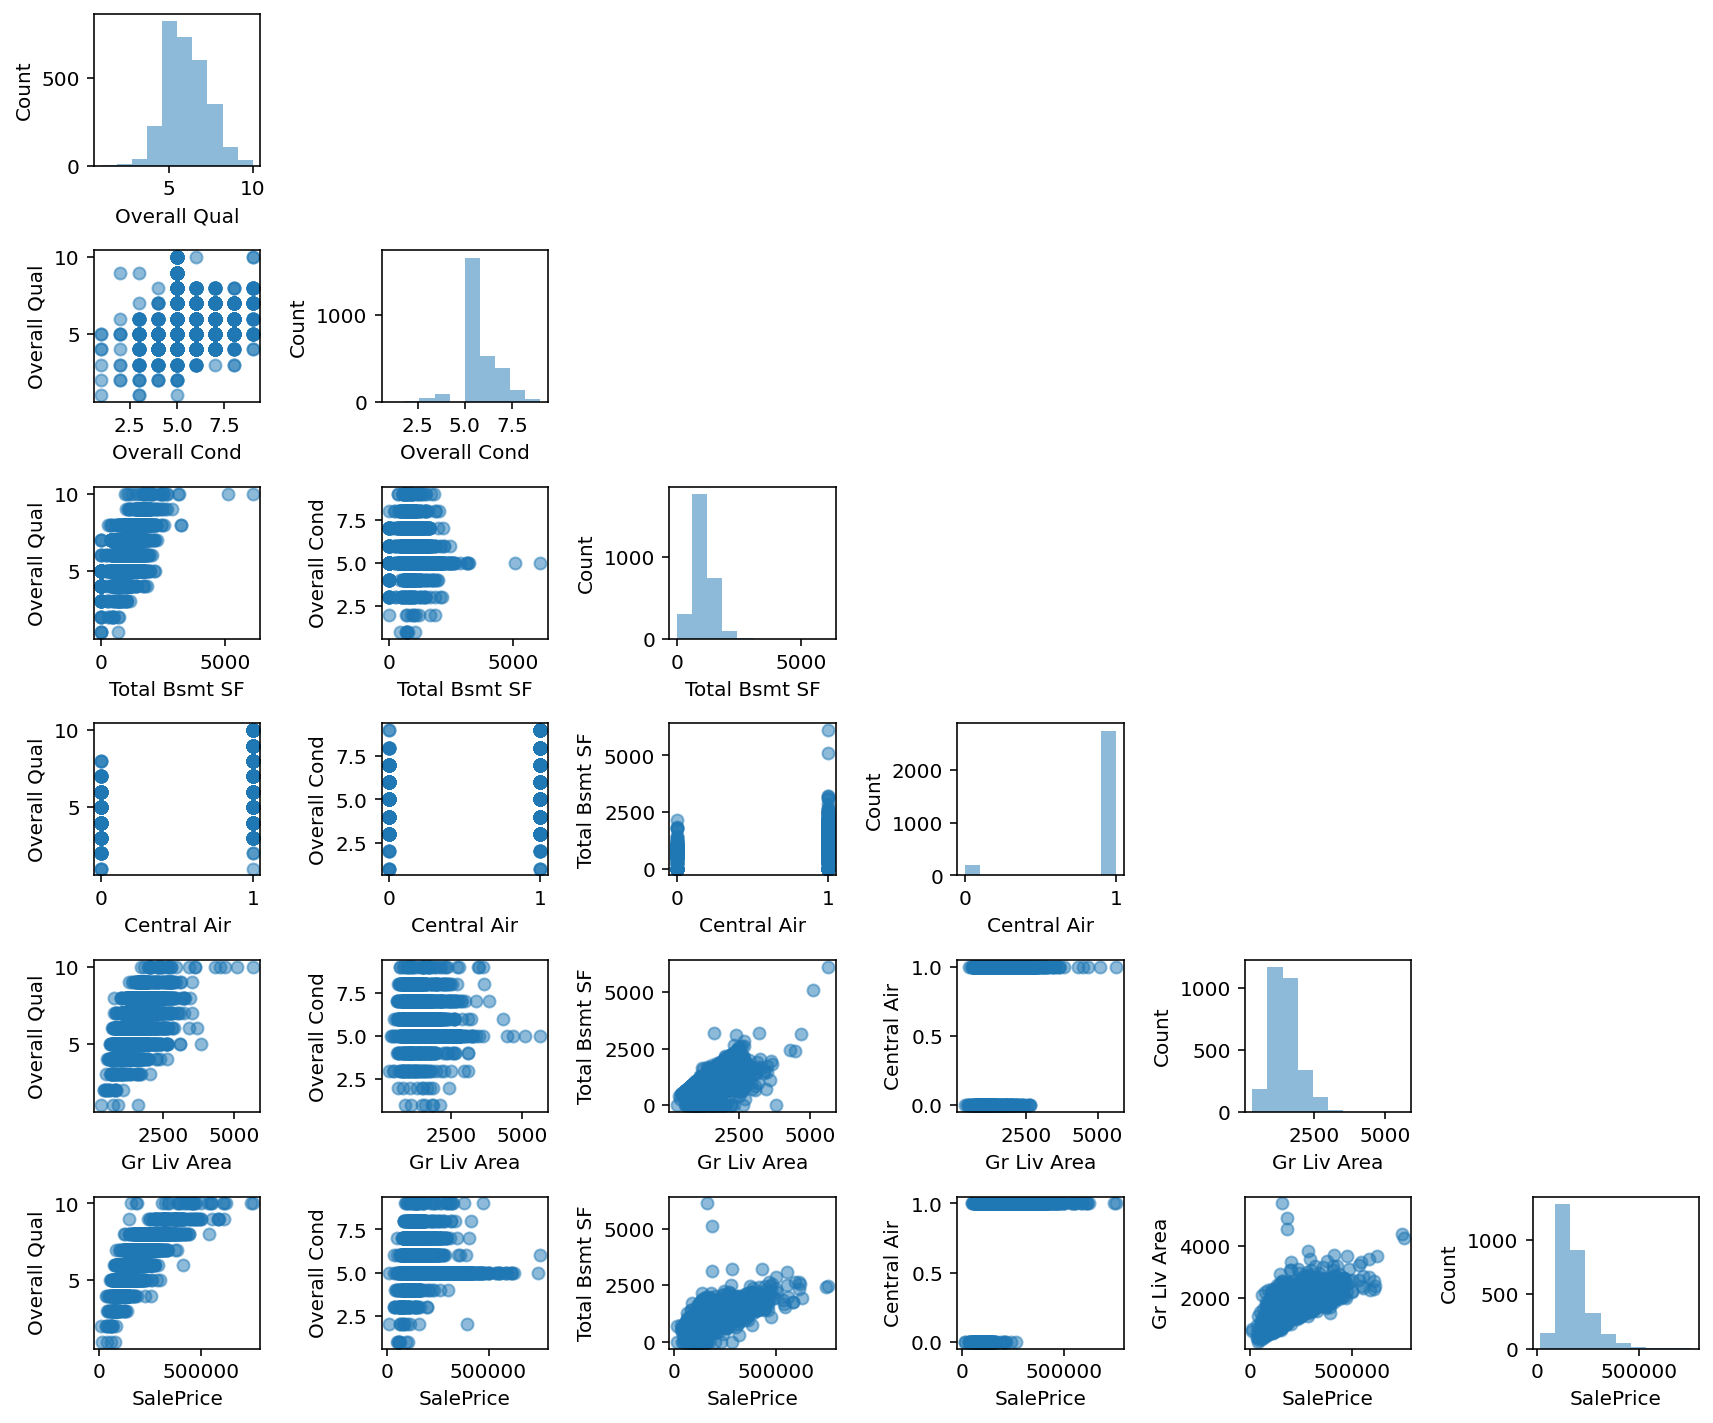

In [10]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

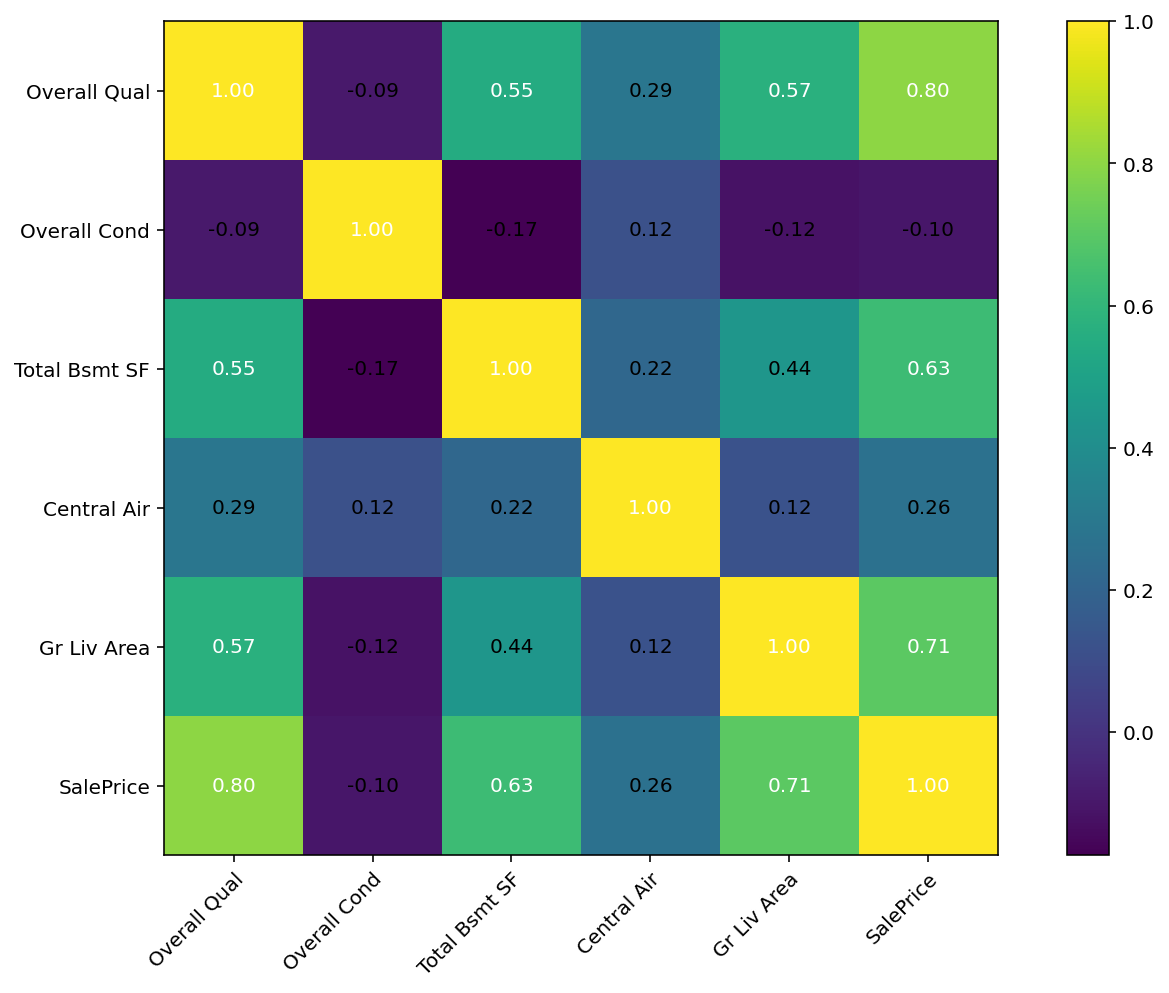

In [11]:
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

In [12]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        return self.net_input(X)

In [13]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

In [14]:
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

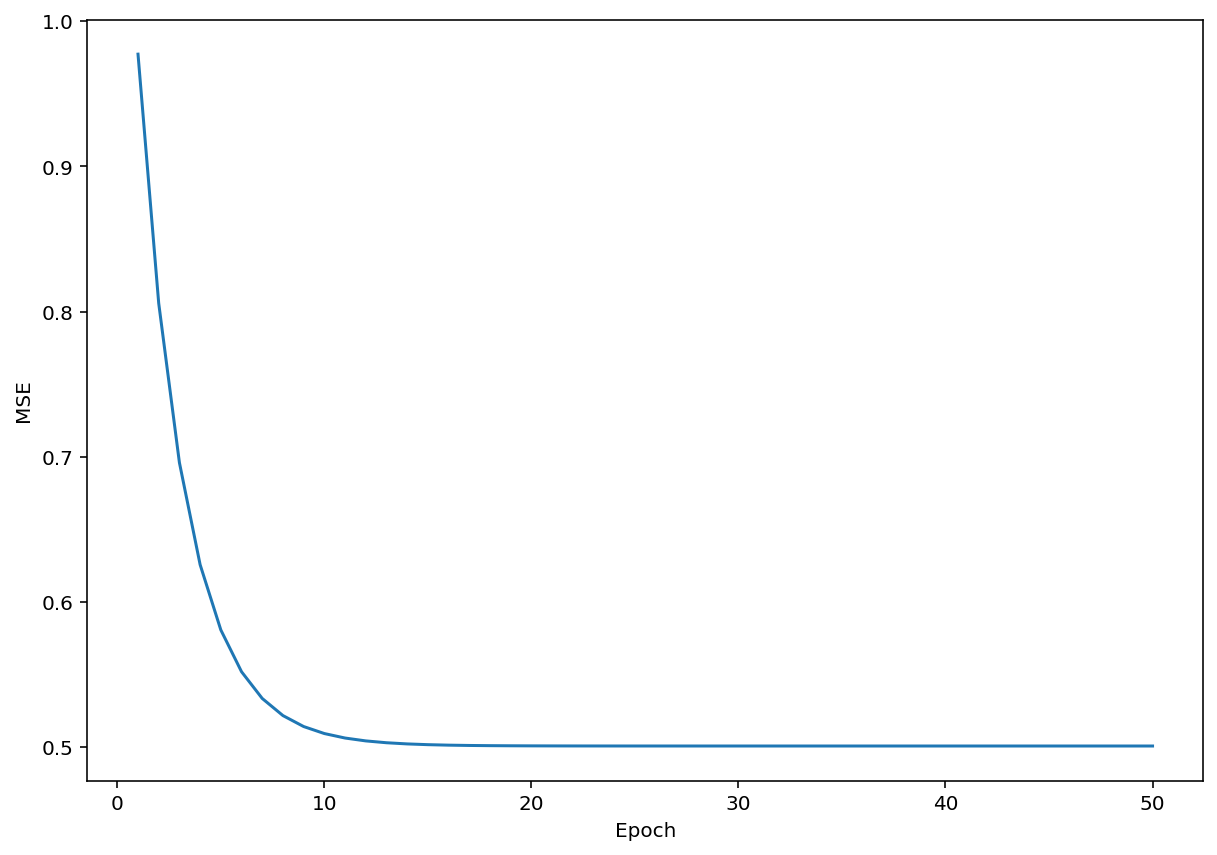

In [15]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [16]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

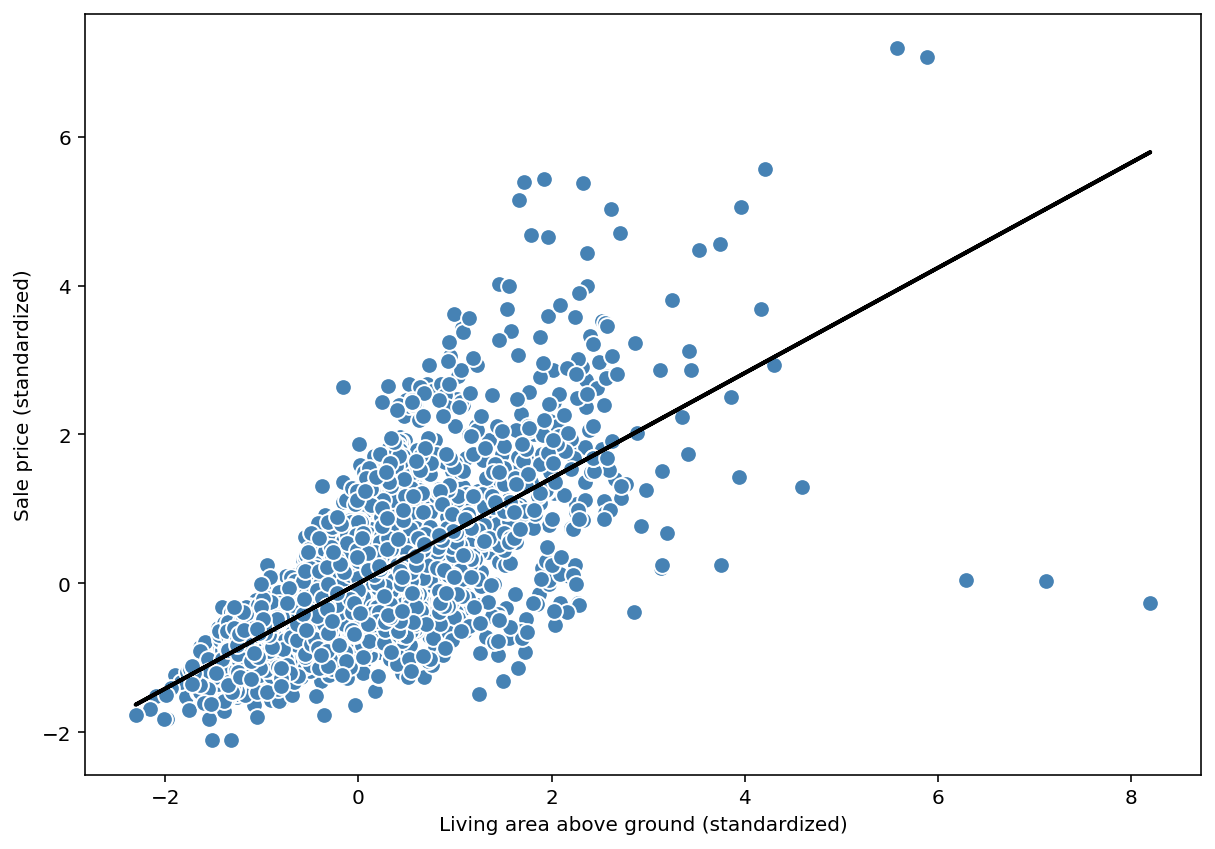

In [17]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [18]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))

print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


In [19]:
print(f'Slope: {lr.w_[0]:.3f}')

Slope: 0.707


In [20]:
print(f'Intercept: {lr.b_[0]:.3f}')

Intercept: -0.000


### Fitting a robust regression model using RANSAC

In [24]:
ransac = RANSACRegressor(
    LinearRegression(),  
    max_trials=100, 
    min_samples=0.95, 
    residual_threshold=None, 
    random_state=123)

In [25]:
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

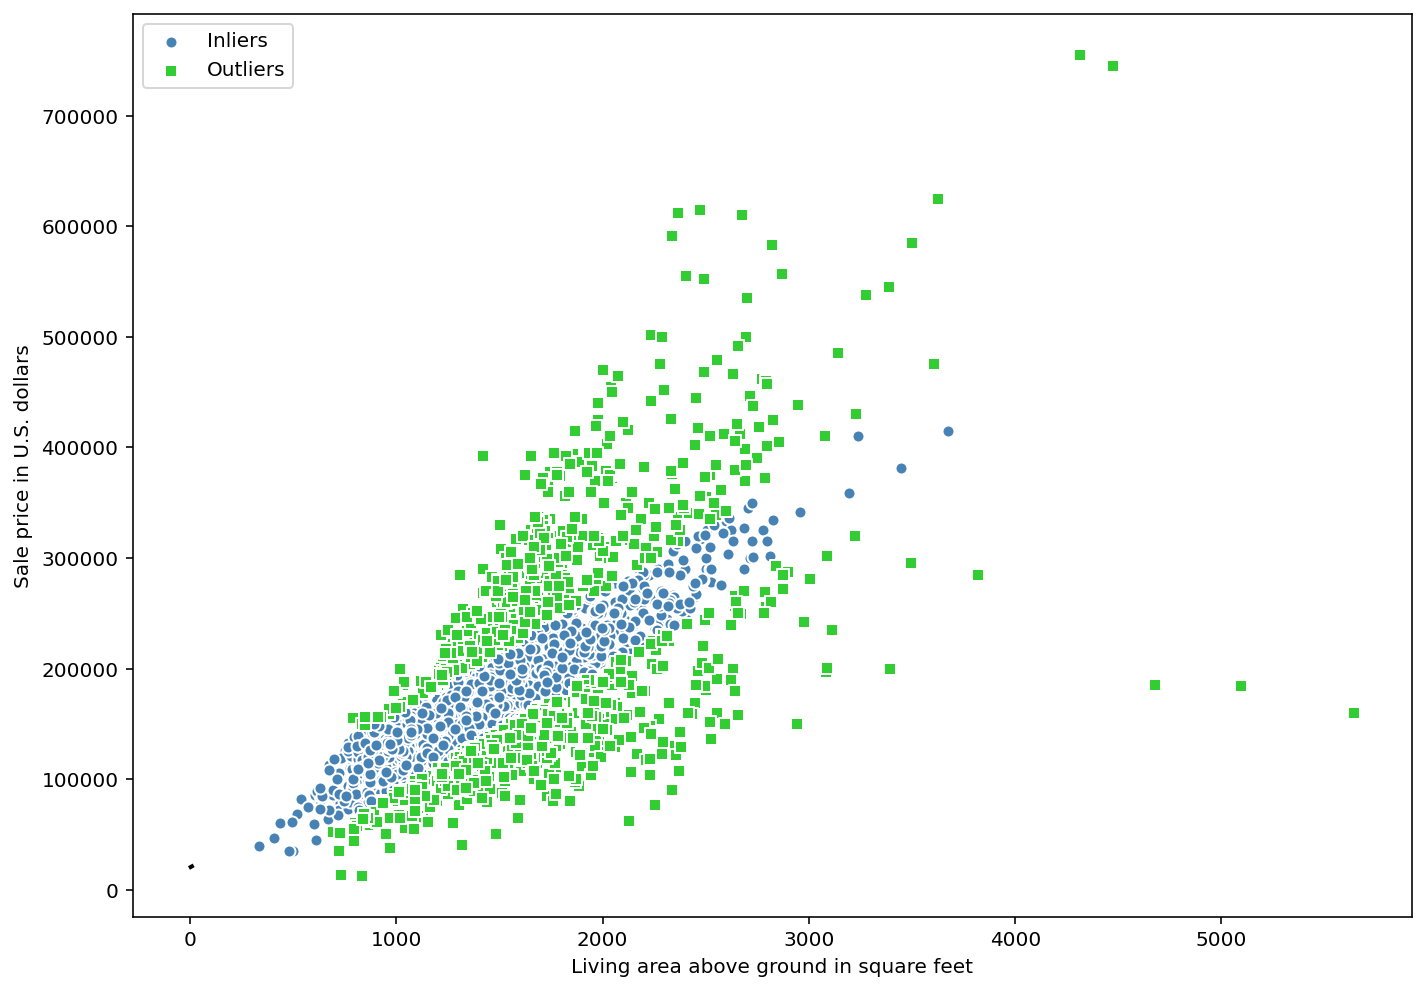

In [27]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')

Slope: 106.348


In [29]:
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Intercept: 20190.093


In [30]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))

mean_absolute_deviation(y)

58269.561754979375